In [0]:
# Change directory to VSCode workspace root so that relative path loads work correctly. Turn this addition off with the DataScience.changeDirOnImportExport setting
# ms-python.python added
import os
try:
	os.chdir(os.path.join(os.getcwd(), '..'))
	print(os.getcwd())
except:
	pass


In [77]:

import os
os.environ['PROJ_LIB'] = r'C:\Users\nobody\Anaconda3\envs\geo\Library\share\proj'
# r'C:\Users\nobody\Anaconda3\envs\geo\Lib\site-packages\pyproj\data'


import numpy as np
import pandas as pd
import cv2
import os, argparse, cntk, tifffile, warnings
from collections import namedtuple
import matplotlib.pyplot as plt
from scipy.special import expit

from osgeo import gdal
from gdalconst import *
import osr

gdal.UseExceptions()


In [78]:
def getPixelDims(img_filename):
    img = gdal.Open(img_filename, GA_ReadOnly)
    img_proj = osr.SpatialReference()
    img_proj.ImportFromWkt(img.GetProjection())
    ulcrnrx, xstep, _, ulcrnry, _, ystep = img.GetGeoTransform()

    return (xstep, ystep)


In [79]:
# The default filename points to your model trained for one epoch.
# You can also try using our sample model, 250epochs.model
#model_filename = r"D:\Prog\Projects\MachineLearning\Misc\Datasets\pixellevellandclassification\models\250epochs.model"
#model = cntk.load_model(model_filename)
#
#naip_filename = r"D:\Prog\Projects\MachineLearning\Misc\Datasets\pixellevellandclassification\evaluation_data\C14_NAIP.tif"
#lc_filename = naip_filename.replace('_NAIP.tif', '_LandCover.tif')
#
#with warnings.catch_warnings():
#    warnings.simplefilter('ignore')
#    naip_image = np.transpose(tifffile.imread(naip_filename))  / 255.0
#    true_lc_image = np.transpose(tifffile.imread(lc_filename))
#true_lc_image[true_lc_image > 4] = 4


In [80]:

region_dim = 256
delta = int(region_dim / 2)
padding = 64
_, imgHeight, imgWidth = naip_image.shape

center_x = 5063
center_y = 533

print(f"Using patch parameters center_x: {center_x}, center_y: {center_y}")



Using patch parameters center_x: 5063, center_y: 533


In [81]:

dataPatch = naip_image[:,
                        center_x - (delta + padding):center_x + delta + padding,
                        center_y - (delta + padding):center_y + delta + padding].astype(
                            np.float32)

groundTruthPatch = true_lc_image[center_x - delta:center_x + delta,
                              center_y - delta:center_y + delta].astype(np.float32)


In [82]:
n_rows = int(region_dim / 128)

# The model's predictions will have five values for each x-y position:
# these can be used to find the relative predicted probabilities of
# each of the five labels.
predictedPatch = np.zeros((5, groundTruthPatch.shape[0], groundTruthPatch.shape[1]))

for row_idx in range(n_rows):
    for col_idx in range(n_rows):
        # Extract a 256 x 256 region from the NAIP image, to feed into the model.
        sq_naip = dataPatch[:,
                             row_idx * 128:(row_idx * 128) + 256,
                             col_idx * 128:(col_idx * 128) + 256]
        
        # Get the model's prediction for the center of that region
        sq_pred_lc = np.squeeze(model.eval({model.arguments[0]: [sq_naip]}))
        
        # Save the predictions in the appropriate region of the result matrix
        predictedPatch[:,
                      row_idx * 128:(row_idx * 128) + 128,
                      col_idx * 128:(col_idx * 128) + 128] = sq_pred_lc


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Statistics


Total overlay area: 65531.70, m^2
No data has 0.00 m^2, 0.00%
Water has 15871.96 m^2, 24.22%
Trees has 49501.75 m^2, 75.54%
Herbaceous has 157.99 m^2, 0.24%
Barren/impervious has 0.00 m^2, 0.00%


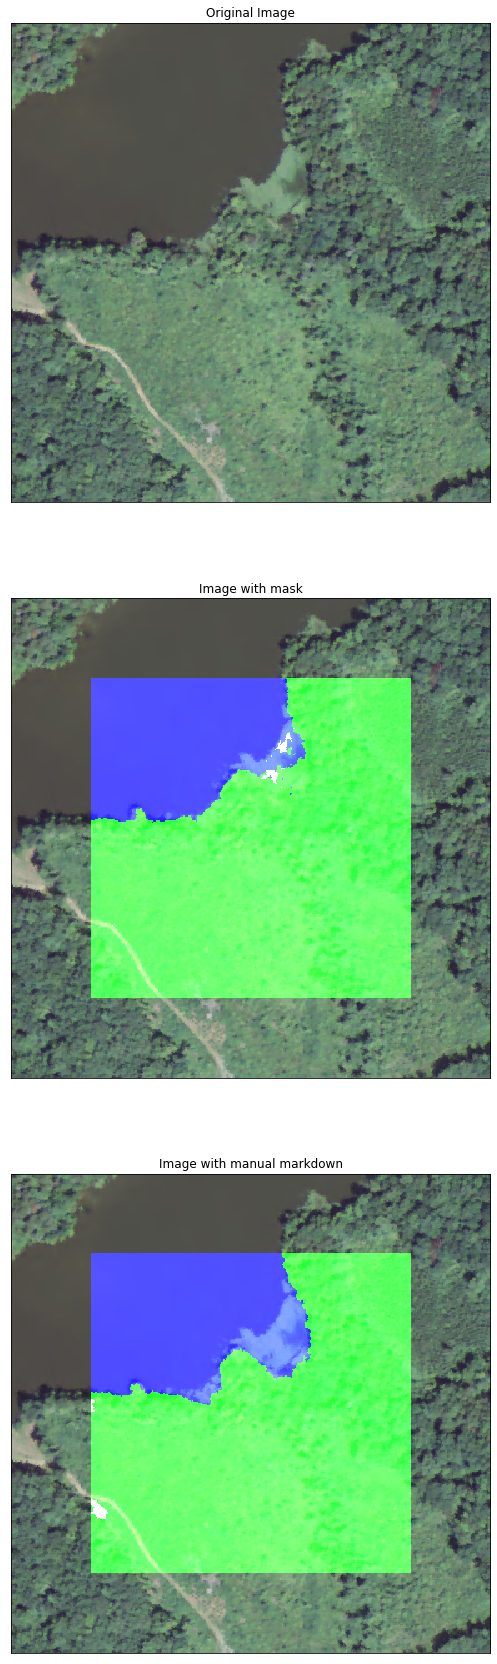

In [83]:

layerNames = [
    "No data",
    "Water",
    "Trees",
    "Herbaceous",
    "Barren/impervious"
]

color_map = np.asarray([[0,0,0],
                        [0,0,1],
                        [0,0.5,0],
                        [0.5,1,0.5],
                        [0.5,0.375,0.375]], dtype=np.float32)

def visualize_label_image(input_image, hard=True):
    num_labels, height, width = input_image.shape
    label_image = np.zeros((3, height, width))
    if hard:
        my_label_indices = input_image.argmax(axis=0)
        for label_idx in range(num_labels):
            for rgb_idx in range(3):
                label_image[rgb_idx, :, :] += (my_label_indices == label_idx) *\
                    color_map[label_idx, rgb_idx]
    else:
        input_image = np.exp(input_image) / np.sum(np.exp(input_image), axis=0)
        for label_idx in range(num_labels):
            for rgb_idx in range(3):
                label_image[rgb_idx, :, :] += input_image[label_idx, :, :] * \
                    color_map[label_idx, rgb_idx]
    label_image = np.transpose(label_image * 255).astype(np.uint8)
    return(label_image)

fig = plt.figure(figsize=(10, 30))
total = 3

def showImg(img, n, title):
    sub = fig.add_subplot(total, 1, n)
    sub.imshow(img)
    sub.set_xticks([])
    sub.set_yticks([])
    sub.set_title(title)

img_labels_pred = visualize_label_image(predictedPatch, hard=True)
true_lc_labels = np.transpose(np.eye(5)[groundTruthPatch.astype(np.int32)], [2, 0, 1])
img_labels_true = visualize_label_image(true_lc_labels, hard=True)

img_shape = (region_dim+2*padding, region_dim+2*padding, 3)

img_labels_pred_full = np.zeros(img_shape, dtype="float32")
img_labels_pred_full[padding:(region_dim+padding),
                     padding:(region_dim+padding), :] = img_labels_pred*10
overlayApplied = cv2.addWeighted(dataPatch[:3].transpose((2,1,0)), 1.0,
                                 img_labels_pred_full, 0.5, 0)

img_labels_true_full = np.zeros(img_shape, dtype="float32")
img_labels_true_full[padding:(region_dim+padding),
                     padding:(region_dim+padding), :] = img_labels_true*10
overlayAppliedTrue = cv2.addWeighted(dataPatch[:3].transpose((2,1,0)), 1.0,
                                 img_labels_true_full, 0.5, 0)


showImg(dataPatch[:3].transpose((2,1,0)), 1, "Original Image")
showImg(overlayApplied, 2, "Image with mask")
showImg(overlayAppliedTrue, 3, "Image with manual markdown")

labelsInPredicted = predictedPatch.argmax(axis=0)
lablesInTrue = true_lc_labels.argmax(axis=0)
(xstep, ystep) = getPixelDims(naip_filename)

metersSqPerPixel = abs(xstep*ystep)
totalOverlayArea = region_dim*region_dim*metersSqPerPixel

layerAreas = {}

for layerIdx in range(len(layerNames)):
    layerArea = np.sum(labelsInPredicted == layerIdx)
    layerAreas[layerNames[layerIdx]] = layerArea*metersSqPerPixel

print("\n\nStatistics\n\n")
print(f"Total overlay area: {totalOverlayArea:.2f}, m^2")
for (k, v) in layerAreas.items():
    print(f"{k} has {v:.2f} m^2, {100*v/totalOverlayArea:.2f}%")

#plt.imshow(img_labels_pred_full)


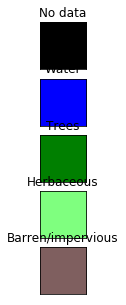

In [84]:
fig = plt.figure(figsize=(5, 5))
total = len(layerNames)

def showImg(img, n, title):
    sub = fig.add_subplot(total, 1, n)
    sub.imshow(img)
    sub.set_xticks([])
    sub.set_yticks([])
    sub.set_title(title)

for i in range(total):
    mapImg = np.full((30, 30, 3), color_map[i])
    showImg(mapImg, i+1, layerNames[i])

